In [1]:
%matplotlib inline

## Setup GPU Device

In [2]:
import os
#Set GPU IDs for training:
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

In [3]:
import dgl
def build_circuit_graph_undirected(node_list,edge_list):
    g = dgl.DGLGraph()
    g.add_nodes(len(node_list))
    src, dst = tuple(zip(*edge_list))
    g.add_edges(src, dst)
    g.add_edges(dst, src)
    return g

def build_circuit_graph_directed_sd(node_list,edge_list):
    g = dgl.DGLGraph()
    g.add_nodes(len(node_list))
    src, dst = tuple(zip(*edge_list))
    g.add_edges(src, dst)
    return g

def build_circuit_graph_directed_ds(node_list,edge_list):
    g = dgl.DGLGraph()
    g.add_nodes(len(node_list))
    src, dst = tuple(zip(*edge_list))
    g.add_edges(dst, src)
    return g

## Imports

In [4]:
import torch.optim as optim
from torch.utils.data import DataLoader

## Choose Number of Training Samples

In [5]:
import matplotlib.pyplot as plt
import networkx as nx
import csv
import numpy as np
dir = 'training_data'

trainset=[]
labels=[]
#for filename in os.listdir(dir):
np.random.seed(0)
# training_idx = np.random.randint(4,64,10)
#non-repeat generation of indices
training_idx = np.random.choice(np.arange(4,64), size=3, replace=False)
print(training_idx)
# seed(0):[48 51 57  4  7 63  7 43 13 23 25 54 40 27 10 28 28 16 62  5]
# seed(1):[41 47 16 12 13 15  9 19  4 20  5 16 11 49 10 29 54 24 41 22]
# seed(2):[44 19 49 12 26 47 22 15 44 11 38 53 35 15 25 51 35 30 24 56]
# seed(2):10 samples [44 19 49 12 26 47 22 15 44 11]
# seed(0):10 samples no repeat: [30 39 63 32 15  6 38 62 44 26]
# seed(0):5 samples no repeat: [30 39 63 32 15]
# seed(0):3 samples no repeat: [30 39 63]
# seed(0):2 samples no repeat: [30 39]

[30 39 63]


In [6]:
labels=[]
for idx in training_idx:
    node_list=[]
    edge_list=[]
    label_list=[]
    node_list2=[]
    edge_list2=[]
    label_list2=[]
    node_list3=[]
    edge_list3=[]
    label_list3=[]
    node_list4=[]
    edge_list4=[]
    label_list4=[]
    for j in ["node_list","edge_list","graph_label"]:
        filename = "cla_"+str(idx)+"bit"+j+'.csv'
        filename2 = "CSkipA_"+str(idx)+"bit"+j+'.csv'
        if(filename.find("node_list")>=0):
            with open(dir+'/'+filename, 'rt') as fh:
                reader=csv.reader(fh)
                node_list = list(reader)
                
        if(filename.find("edge_list")>=0):
            with open(dir+'/'+filename, 'rt') as fh:
                reader=csv.reader(fh)
                edge_list = list(reader)
        if(filename.find("graph_label")>=0):
            with open(dir+'/'+filename, 'rt') as fh:
                reader=csv.reader(fh)
                label_list = list(reader)
        if(filename.find("gate_type")>=0):
            with open(dir+'/'+filename, 'rt') as fh:
                reader=csv.reader(fh)
                gate_type = list(reader)
        
        if(filename2.find("node_list")>=0):
            with open(dir+'/'+filename2, 'rt') as fh:
                reader=csv.reader(fh)
                node_list2 = list(reader)
                
        if(filename2.find("edge_list")>=0):
            with open(dir+'/'+filename2, 'rt') as fh:
                reader=csv.reader(fh)
                edge_list2 = list(reader)
        if(filename2.find("graph_label")>=0):
            with open(dir+'/'+filename2, 'rt') as fh:
                reader=csv.reader(fh)
                label_list2 = list(reader)
        if(filename2.find("gate_type")>=0):
            with open(dir+'/'+filename2, 'rt') as fh:
                reader=csv.reader(fh)
                gate_type2 = list(reader)
        
    #create dgl graph
    g=build_circuit_graph_undirected(node_list,edge_list)
    trainset.append(g)
    labels.append(label_list[0])
    g2=build_circuit_graph_undirected(node_list2,edge_list2)
    trainset.append(g2)
    labels.append(['1'])

print(labels)
for i in labels:
    i[0] = int(i[0])

print(labels)

[['0'], ['1'], ['0'], ['1'], ['0'], ['1']]
[[0], [1], [0], [1], [0], [1]]


In [7]:
# graph = trainset[14]
# label=labels[14][0]

# fig, ax = plt.subplots()
# G=graph.to_networkx()
# pos=nx.spring_layout(G)
# nx.draw(G,pos)
# nx.draw_networkx_labels(G,pos, ax=ax)
# ax.set_title('Class: {:f}'.format(label))
# plt.show()

## Apply random shuffle to training set

In [8]:
##apply random shuffle on the trainset
np.random.seed(0)
randomize = np.arange(len(trainset))
np.random.shuffle(randomize)
labels_shuffled=[]
trainset_shuffled=[]
for i in range (len(randomize)):
    labels_shuffled.append(labels[randomize[i]])
    trainset_shuffled.append(trainset[randomize[i]])

In [9]:
print(randomize)

[5 2 1 3 0 4]


In [10]:
import dgl

def collate(samples):
    # The input `samples` is a list of pairs
    #  (graph, label).
    graphs, labels = map(list, zip(*samples))
    batched_graph = dgl.batch(graphs)
    return batched_graph, torch.tensor(labels)

In [11]:
import dgl.function as fn
import torch
import torch.nn as nn


# Sends a message of node feature h.
msg = fn.copy_src(src='h', out='m')

def reduce(nodes):
    """Take an average over all neighbor node features hu and use it to
    overwrite the original node feature."""
    accum = torch.mean(nodes.mailbox['m'], 1)
    return {'h': accum}

class NodeApplyModule(nn.Module):
    """Update the node feature hv with ReLU(Whv+b)."""
    def __init__(self, in_feats, out_feats, activation):
        super(NodeApplyModule, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats)
        self.activation = activation

    def forward(self, node):
        h = self.linear(node.data['h'])
        h = self.activation(h)
        return {'h' : h}

class GCN(nn.Module):
    def __init__(self, in_feats, out_feats, activation):
        super(GCN, self).__init__()
        self.apply_mod = NodeApplyModule(in_feats, out_feats, activation)

    def forward(self, g, feature):
        # Initialize the node features with h.
        g.ndata['h'] = feature
        g.update_all(msg, reduce)
        g.apply_nodes(func=self.apply_mod)
        return g.ndata.pop('h')

Readout and classification
--------------------------
For this demonstration, consider initial node features to be their degrees.
After two rounds of graph convolution, perform a graph readout by averaging
over all node features for each graph in the batch.

\begin{align}h_g=\frac{1}{|\mathcal{V}|}\sum_{v\in\mathcal{V}}h_{v}\end{align}

In DGL, :func:`dgl.mean_nodes` handles this task for a batch of
graphs with variable size. You then feed the graph representations into a
classifier with one linear layer to obtain pre-softmax logits.



In [12]:
import torch.nn.functional as F


class Classifier(nn.Module):
    def __init__(self, in_dim, hidden_dim, n_classes):
        super(Classifier, self).__init__()

        self.layers = nn.ModuleList([
            GCN(in_dim, hidden_dim, F.relu),
            GCN(hidden_dim, hidden_dim, F.relu)])
        self.classify = nn.Linear(hidden_dim, n_classes)

    def forward(self, g):
        # For undirected graphs, in_degree is the same as
        # out_degree.
        h = g.in_degrees().view(-1, 1).float().cuda()
        for conv in self.layers:
            h = conv(g, h)
        g.ndata['h'] = h
        hg = dgl.mean_nodes(g, 'h')
        return self.classify(hg)

Setup and training
------------------
Create a synthetic dataset of $400$ graphs with $10$ ~
$20$ nodes. $320$ graphs constitute a training set and
$80$ graphs constitute a test set.



In [13]:
len(trainset_shuffled)

6

In [14]:
# Create model
#model = Classifier(1, 256, trainset.num_classes)
model = Classifier(1, 256, 2)
model.cuda()
loss_func = nn.CrossEntropyLoss().cuda()
optimizer = optim.Adam(model.parameters(), lr=0.001)
model.train()

labels_shuffled = torch.LongTensor(labels_shuffled).cuda()

epoch_losses = []
for epoch in range(500):
    model.train()
    epoch_loss = 0
    for iter, bg in enumerate(trainset_shuffled):
        prediction=torch.zeros(1,2,dtype=torch.float64).cuda()
        prediction[0] = model(bg)

        loss = loss_func(prediction, labels_shuffled[iter])
        optimizer.zero_grad()
        loss.backward()
        
        #add in gradient clipping:
        
        optimizer.step()
        epoch_loss += loss.detach().item()
    epoch_loss /= (iter + 1)
    print('Epoch {}, loss {:.4f}'.format(epoch, epoch_loss))
    epoch_losses.append(epoch_loss)
    
    if (epoch%5==0):
        model.eval()
        eval_bg = dgl.batch(trainset_shuffled)
        eval_labels = torch.tensor(labels_shuffled).float().view(-1, 1)
        probs_Y = torch.softmax(model(eval_bg), 1)
        argmax_Y = torch.max(probs_Y, 1)[1].view(-1, 1)

        print('Accuracy of argmax predictions on the training set: {:4f}%'.format(
            (eval_labels == argmax_Y.float()).sum().item() / len(eval_labels) * 100))

Epoch 0, loss 0.9953
Accuracy of argmax predictions on the training set: 50.000000%
Epoch 1, loss 0.6796
Epoch 2, loss 0.7923
Epoch 3, loss 0.7599


/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch 4, loss 0.7177
Epoch 5, loss 0.7059
Accuracy of argmax predictions on the training set: 50.000000%
Epoch 6, loss 0.7266
Epoch 7, loss 0.7299
Epoch 8, loss 0.7211
Epoch 9, loss 0.7148
Epoch 10, loss 0.7174
Accuracy of argmax predictions on the training set: 50.000000%
Epoch 11, loss 0.7204
Epoch 12, loss 0.7194
Epoch 13, loss 0.7169
Epoch 14, loss 0.7160
Epoch 15, loss 0.7163
Accuracy of argmax predictions on the training set: 100.000000%
Epoch 16, loss 0.7165
Epoch 17, loss 0.7158
Epoch 18, loss 0.7147
Epoch 19, loss 0.7141
Epoch 20, loss 0.7142
Accuracy of argmax predictions on the training set: 100.000000%
Epoch 21, loss 0.7138
Epoch 22, loss 0.7131
Epoch 23, loss 0.7123
Epoch 24, loss 0.7123
Epoch 25, loss 0.7120
Accuracy of argmax predictions on the training set: 100.000000%
Epoch 26, loss 0.7112
Epoch 27, loss 0.7106
Epoch 28, loss 0.7105
Epoch 29, loss 0.7103
Epoch 30, loss 0.7096
Accuracy of argmax predictions on the training set: 100.000000%
Epoch 31, loss 0.7089
Epoch 32

Epoch 236, loss 0.4881
Epoch 237, loss 0.4833
Epoch 238, loss 0.4807
Epoch 239, loss 0.4770
Epoch 240, loss 0.4781
Accuracy of argmax predictions on the training set: 100.000000%
Epoch 241, loss 0.4741
Epoch 242, loss 0.4643
Epoch 243, loss 0.4649
Epoch 244, loss 0.4589
Epoch 245, loss 0.4572
Accuracy of argmax predictions on the training set: 100.000000%
Epoch 246, loss 0.4517
Epoch 247, loss 0.4504
Epoch 248, loss 0.4459
Epoch 249, loss 0.4417
Epoch 250, loss 0.4394
Accuracy of argmax predictions on the training set: 100.000000%
Epoch 251, loss 0.4349
Epoch 252, loss 0.4314
Epoch 253, loss 0.4276
Epoch 254, loss 0.4251
Epoch 255, loss 0.4208
Accuracy of argmax predictions on the training set: 100.000000%
Epoch 256, loss 0.4167
Epoch 257, loss 0.4141
Epoch 258, loss 0.4094
Epoch 259, loss 0.4065
Epoch 260, loss 0.4016
Accuracy of argmax predictions on the training set: 100.000000%
Epoch 261, loss 0.3990
Epoch 262, loss 0.3959
Epoch 263, loss 0.3910
Epoch 264, loss 0.3881
Epoch 265, lo

Epoch 467, loss 0.0491
Epoch 468, loss 0.0532
Epoch 469, loss 0.0510
Epoch 470, loss 0.0569
Accuracy of argmax predictions on the training set: 100.000000%
Epoch 471, loss 0.0538
Epoch 472, loss 0.0610
Epoch 473, loss 0.0586
Epoch 474, loss 0.0653
Epoch 475, loss 0.0607
Accuracy of argmax predictions on the training set: 100.000000%
Epoch 476, loss 0.0648
Epoch 477, loss 0.0591
Epoch 478, loss 0.0644
Epoch 479, loss 0.0599
Epoch 480, loss 0.0635
Accuracy of argmax predictions on the training set: 100.000000%
Epoch 481, loss 0.0594
Epoch 482, loss 0.0652
Epoch 483, loss 0.0602
Epoch 484, loss 0.0648
Epoch 485, loss 0.0612
Accuracy of argmax predictions on the training set: 100.000000%
Epoch 486, loss 0.0647
Epoch 487, loss 0.0592
Epoch 488, loss 0.0648
Epoch 489, loss 0.0618
Epoch 490, loss 0.0653
Accuracy of argmax predictions on the training set: 100.000000%
Epoch 491, loss 0.0629
Epoch 492, loss 0.0645
Epoch 493, loss 0.0608
Epoch 494, loss 0.0656
Epoch 495, loss 0.0658
Accuracy of a

The learning curve of a run is presented below.



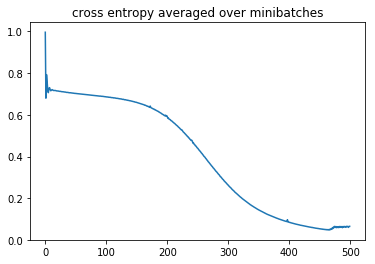

In [15]:
plt.title('cross entropy averaged over minibatches')
plt.plot(epoch_losses)
plt.show()

## Finish Training

## Get Testset data

In [23]:
testset = []
test_labels = []
test_dir = 'test_data'

testing_idx=[]
for i in range(4,65):
    if i not in training_idx:
        testing_idx.append(i)

print(testing_idx)
print(training_idx)

[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 32, 33, 34, 35, 36, 37, 38, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 64]
[30 39 63]


In [24]:
len(testing_idx)

58

In [25]:
for idx in testing_idx:
    node_list=[]
    edge_list=[]
    label_list=[]
    node_list2=[]
    edge_list2=[]
    label_list2=[]
    node_list3=[]
    edge_list3=[]
    label_list3=[]
    node_list4=[]
    edge_list4=[]
    label_list4=[]
    for j in ["node_list","edge_list","graph_label"]:
        filename = "cla_"+str(idx)+"bit"+j+'.csv'
        filename2 = "CSkipA_"+str(idx)+"bit"+j+'.csv'
        
        if(filename.find("node_list")>=0):
            with open(test_dir+'/'+filename, 'rt') as fh:
                reader=csv.reader(fh)
                node_list = list(reader)
                
        if(filename.find("edge_list")>=0):
            with open(test_dir+'/'+filename, 'rt') as fh:
                reader=csv.reader(fh)
                edge_list = list(reader)
        if(filename.find("graph_label")>=0):
            with open(test_dir+'/'+filename, 'rt') as fh:
                reader=csv.reader(fh)
                label_list = list(reader)
        if(filename.find("gate_type")>=0):
            with open(test_dir+'/'+filename, 'rt') as fh:
                reader=csv.reader(fh)
                gate_type = list(reader)
        
        if(filename2.find("node_list")>=0):
            with open(test_dir+'/'+filename2, 'rt') as fh:
                reader=csv.reader(fh)
                node_list2 = list(reader)
                
        if(filename2.find("edge_list")>=0):
            with open(test_dir+'/'+filename2, 'rt') as fh:
                reader=csv.reader(fh)
                edge_list2 = list(reader)
        if(filename2.find("graph_label")>=0):
            with open(test_dir+'/'+filename2, 'rt') as fh:
                reader=csv.reader(fh)
                label_list2 = list(reader)
        if(filename2.find("gate_type")>=0):
            with open(test_dir+'/'+filename2, 'rt') as fh:
                reader=csv.reader(fh)
                gate_type2 = list(reader)
    #create dgl graph
    g=build_circuit_graph_undirected(node_list,edge_list)
    testset.append(g)
    test_labels.append(label_list[0])
    g2=build_circuit_graph_undirected(node_list2,edge_list2)
    testset.append(g2)
    test_labels.append(['1'])


for i in test_labels:
    i[0] = int(i[0])

print(test_labels)

[[0], [1], [0], [1], [0], [1], [0], [1], [0], [1], [0], [1], [0], [1], [0], [1], [0], [1], [0], [1], [0], [1], [0], [1], [0], [1], [0], [1], [0], [1], [0], [1], [0], [1], [0], [1], [0], [1], [0], [1], [0], [1], [0], [1], [0], [1], [0], [1], [0], [1], [0], [1], [0], [1], [0], [1], [0], [1], [0], [1], [0], [1], [0], [1], [0], [1], [0], [1], [0], [1], [0], [1], [0], [1], [0], [1], [0], [1], [0], [1], [0], [1], [0], [1], [0], [1], [0], [1], [0], [1], [0], [1], [0], [1], [0], [1], [0], [1], [0], [1], [0], [1], [0], [1], [0], [1], [0], [1], [0], [1], [0], [1], [0], [1], [0], [1]]


In [26]:
##apply random shuffle on the testset   
np.random.seed(0)
randomize = np.arange(len(testset))
np.random.shuffle(randomize)
testset_shuffled=[]
test_labels_shuffled=[]
for i in range (len(randomize)):
    test_labels_shuffled.append(test_labels[randomize[i]])
    testset_shuffled.append(testset[randomize[i]])
print(randomize)

[ 10  74  66  51   7  78  92  90 107  62  30   2  94  22  43  84  24  73
  60  56  16  13  26  86  71  97 111 100   8  93  33  45   3  48   6  54
 115  95 101  96  91  63  27  18  11  59  68  61  76  50   1 104  42  41
   4  15  17  52  40  38   5  53 106 108   0  34  28  55  35  23  31  75
  57  89  99  32  98  14  85  19  29  49  82 113 114  79  69  80  20 109
  72  77  25  37  81 102  46 105  39  65  58  12 110  88  70  87  36  21
  83   9 103 112  67  64  47  44]


In [27]:
len(testset_shuffled)

116

In [28]:
print(argmax_Y.size())

torch.Size([116, 1])


In [29]:
model.eval()
test_bg = dgl.batch(testset_shuffled)
test_labels = torch.tensor(test_labels_shuffled).float().view(-1, 1).cuda()
probs_Y = torch.softmax(model(test_bg), 1)

sampled_Y = torch.multinomial(probs_Y, 1)
argmax_Y = torch.max(probs_Y, 1)[1].view(-1, 1)
print('Accuracy of sampled predictions on the test set: {:.4f}%'.format(
    (test_labels == sampled_Y.float()).sum().item() / len(test_labels) * 100))
print('Accuracy of argmax predictions on the test set: {:4f}%'.format(
    (test_labels == argmax_Y.float()).sum().item() / len(test_labels) * 100))

zip(model(test_bg),(test_labels))
for i1,i2 in zip(probs_Y,(test_labels)):
    print(i1,i2)
# print(torch.max(probs_Y, 1))

Accuracy of sampled predictions on the test set: 92.2414%
Accuracy of argmax predictions on the test set: 100.000000%
tensor([0.9296, 0.0704], device='cuda:0', grad_fn=<SelectBackward>) tensor([0.], device='cuda:0')
tensor([0.9324, 0.0676], device='cuda:0', grad_fn=<SelectBackward>) tensor([0.], device='cuda:0')
tensor([0.7627, 0.2373], device='cuda:0', grad_fn=<SelectBackward>) tensor([0.], device='cuda:0')
tensor([0.0077, 0.9923], device='cuda:0', grad_fn=<SelectBackward>) tensor([1.], device='cuda:0')
tensor([0.0116, 0.9884], device='cuda:0', grad_fn=<SelectBackward>) tensor([1.], device='cuda:0')
tensor([0.9275, 0.0725], device='cuda:0', grad_fn=<SelectBackward>) tensor([0.], device='cuda:0')
tensor([0.9308, 0.0692], device='cuda:0', grad_fn=<SelectBackward>) tensor([0.], device='cuda:0')
tensor([0.9392, 0.0608], device='cuda:0', grad_fn=<SelectBackward>) tensor([0.], device='cuda:0')
tensor([0.0051, 0.9949], device='cuda:0', grad_fn=<SelectBackward>) tensor([1.], device='cuda:0')


In [30]:
import tsne

#m = trainset[0].adjacency_matrix()
m = model(test_bg).cpu().data.numpy()


In [31]:
Y = tsne.tsne(m, 2, 30)

Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 116...
Mean value of sigma: 0.296336
Iteration 10: error is 9.028207
Iteration 20: error is 8.641590
Iteration 30: error is 9.796931
Iteration 40: error is 9.088763
Iteration 50: error is 9.126360
Iteration 60: error is 8.927308
Iteration 70: error is 8.736146
Iteration 80: error is 8.550334
Iteration 90: error is 8.490677
Iteration 100: error is 8.488299
Iteration 110: error is 0.964325
Iteration 120: error is 0.668839
Iteration 130: error is 0.485058
Iteration 140: error is 0.267286
Iteration 150: error is 0.110439
Iteration 160: error is 0.067484
Iteration 170: error is 0.046610
Iteration 180: error is 0.043015
Iteration 190: error is 0.042008
Iteration 200: error is 0.041902
Iteration 210: error is 0.041786
Iteration 220: error is 0.041675
Iteration 230: error is 0.041547
Iteration 240: error is 0.041421
Iteration 250: error is 0.041294
Iteration 260: error is 0.041174
Iteration 27

In [43]:
print(Y)

[[ 13.4228394  -11.49259042]
 [-10.21815194  14.23977827]
 [  8.43736586 -15.24965017]
 [  8.78063637 -15.76906534]
 [  9.27310843 -14.73426781]
 [  8.40072757 -15.2754915 ]
 [-10.59810131  13.85570675]
 [ 12.78680992 -11.54748612]
 [  8.93477065 -15.56504416]
 [ 12.26983167 -12.38527972]
 [-12.51148492  11.9262152 ]
 [  9.55700061 -14.75301034]
 [-13.06505887  11.36833234]
 [ -9.52968842  15.02966089]
 [  8.3702075  -15.30340927]
 [ 14.23574809 -10.71807669]
 [-11.54574185  12.89988869]
 [ -9.90346911  14.55621915]
 [ -8.68757923  15.42845312]
 [  9.54863858 -14.85499713]
 [  9.54501187 -14.86053335]
 [  8.47866222 -15.87555294]
 [ 12.30528034 -12.35644408]
 [  9.7280896  -14.53890422]
 [  8.88728147 -15.64558992]
 [ -9.29156731  15.64513958]
 [  8.26430005 -15.49070259]
 [-10.21775002  14.23979359]
 [ 13.34288083 -11.74265156]
 [ 12.91721116 -11.47363963]
 [-13.59945858  10.83951361]
 [  9.26806281 -15.12627084]
 [ -9.04622642  15.04507402]
 [ -9.52968873  15.02966257]
 [-10.59827579

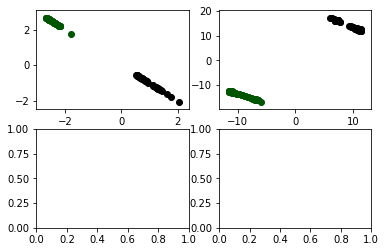

In [32]:
fig, axs = plt.subplots(2,2)

color = test_labels.cpu()*85/255
for i in range (len(test_labels)):
    axs[0,0].scatter(m[i,0],m[i,1],color=(0,color[i],0))
    axs[0,1].scatter(Y[i,0],Y[i,1],color=(0,color[i],0))
   
plt.show()

## End